## Lipinski's Rule of Five (Ro5) - FDA approved drugs (2004 - 2021)

This is an exercise to assess the validity of the Lipinski's Rule of Five (Ro5) of approved drugs (2004-2021). It's the first step of the Exploratory Data Analysis (EDA) and other further analysis along the way. This piece of code was done with the help of @arturcgs

We begin by setting up the enviroment (teachopencadd) and <b>importing libraries</b> used for the analysis

In [83]:
#importing databases
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, Draw, PandasTools
import pandas as pd
import numpy as np
import re

FileNotFoundError: Could not find module 'C:\Users\Gustavo Marques\anaconda3\envs\teachopencadd\lib\site-packages\scipy\.libs\libbanded5x.TNNMG3IXHGJK7NIBT5J6YPEO5XWTOQAJ.gfortran-win_amd64.dll' (or one of its dependencies). Try using the full path with constructor syntax.

After importing the libraries we begin to treat the datasets:

### 1) Data retrieved from Drug Bank (manual downloaded)

#### Firstly, after retrieving the dataset of approved drugs, manually downloaded at the drugbank servers, we treat the dataset
We can both work with the SDF file or read a ready-to-work csv. For this piece of code, we use the csv file. 

After reading the file, we select only useful columns and select the "Name" column, transforming the drugs' names to lower case making it easier to work if we need to compare the names.

In [2]:
## Working with the csv database
approved_drugs = pd.read_csv("structure links.csv")
approved_drugs.columns #checking colum names

approved_drugs = approved_drugs[["Name", "DrugBank ID", "Drug Groups", "SMILES"]] #selecting only useful columns
approved_drugs.head(5)

#letting the drug names be all LOWER
approved_drugs["Name"] = approved_drugs["Name"].str.lower() 
approved_drugs["active"] = approved_drugs["Name"]

approved_drugs = approved_drugs.drop("Name", axis = 1) #removing the "name variable"
approved_drugs.head(5)

print(approved_drugs["active"].shape)
print(approved_drugs.drop_duplicates(subset = "active", keep = "first").shape) #we dont have any duplicates

(2715,)
(2715, 4)


In [3]:
## Working with SDF FILE (Optional)
#handling sdf file
""""approved_molecules_raw = Chem.SDMolSupplier("open structures.sdf")
approved_molecules = [molecule for molecule in approved_molecules_raw]

#transforming sdf files into dataframes
frame = PandasTools.LoadSDF("open structures.sdf",smilesName='SMILES',molColName='Molecule',
           includeFingerprints=True)

#checking the name of columns
frame.columns"""

'"approved_molecules_raw = Chem.SDMolSupplier("open structures.sdf")\napproved_molecules = [molecule for molecule in approved_molecules_raw]\n\n#transforming sdf files into dataframes\nframe = PandasTools.LoadSDF("open structures.sdf",smilesName=\'SMILES\',molColName=\'Molecule\',\n           includeFingerprints=True)\n\n#checking the name of columns\nframe.columns'

### 2) Data retrieved from FDA acess data (manual downloaded)

In order to assess the Ro5 validity we need to see which drugs were approved between 2004 (Lipinski's rule first publication) and 2021. Unfortunately the DrugBank dataset do not include the approval year for each molecule. 

A dataset retrieved from https://www.fda.gov/drugs/drug-approvals-and-databases/compilation-cder-new-molecular-entity-nme-drug-and-new-biologic-approvals contains the New Chemical and Biological Entities approved by year. We can use the information to gather the SMILES.

After downloading manually the dataset, we begin to treat and manipulate it for further data analysis.

In [4]:
# This dataset was retrieved from: 
# https://www.fda.gov/drugs/drug-approvals-and-databases/compilation-cder-new-molecular-entity-nme-drug-and-new-biologic-approvals
fda_total = pd.read_excel("NME_NBA_1985_2021_total.xlsx")
fda_total = fda_total[["Active Ingredient/Moiety", "NDA/BLA", "Approval Year"]]

# filtering for further lipinski analysis YEAR > 2004 ANN ONLY NDA (NOT BIOLOGICAL)
fda_lipinski  = fda_total.loc[(fda_total["NDA/BLA"] == "NDA") & (fda_total["Approval Year"] >= 2004)].reset_index(drop = True)

# cleaning the names of the dataset
fda_lipinski.rename(columns={'Active Ingredient/Moiety': 'active_ingredient_moiety', 
                             'NDA/BLA': 'nda_bla', 'Approval Year': 'approval_year'}, inplace=True) #renaming columns

# one thing worth mentioning is the salt is always after the active ingredient (almost always) so lets separate the two columns
fda_lipinski.head(5)

,active_ingredient_moiety,nda_bla,approval_year
0,tiotropium bromide,NDA,2004
1,pemetrexed disodium,NDA,2004
2,cinacalcet hydrochloride,NDA,2004
3,telithromycin,NDA,2004
4,human secretin,NDA,2004


We can observe above that the dataset contains basically the active ingredient, the nda or bla (biological) and the approval year. 
<b>We select all the active ingredients that meets the criteria: NDA (not biological) and approval year (2004-2021).</b>

We are left with TWO CHOICES: Merging the DrugBank dataset with the FDA approved using the active ingredient as key merger OR we can build a piece of code that searches the SMILE using the active name. This will be further down the process.

If we want to search the SMILE using the name we must, first of all, separate the salt of the proper active active name. 

In [5]:
# we split the active ingredients into active and respective salt
fda_lipinski[["active", "salt"]] = fda_lipinski["active_ingredient_moiety"].str.split(expand = True, n = 1)
print(fda_lipinski.shape) #so we have 477 approved drugs in this period (2021-2004) according to FDA database

(477, 5)


After removing the duplicates, we are left with 471 non-duplicates. We also noticed one thing: some of the rows have lots of active ingredients and have <b>"packaged together"</b> we need to <b>REMOVE</b> them.

### 2.1) Searching SMILES through active name

I wrote the dataframe to csv and explored it in excel in order to get a feeling of what is going on.. so we found that we need:
1) to strip the name from the salts<p>
2) to remove the radioactives (mainly with numbers like F 18, etc)<p>
3) to remove the ASSOCIATIONS (the comma is present on these rows and sometimes the expression "(co-packaged)")

In [6]:
# fda_lipinski.to_csv("fda_lipinski_raw.csv") 
# We wrote the dataframe to csv in order to get a feeling of what is going on.. so we found that we need:
# 1) to remove the salts
# 2) to remove the radioactives (mainly with numbers like F 18, etc)
# 3) to remove the ASSOCIATIONS (the comma is present on these rows and sometimes the expression "(co-packaged)")
# 4) drop the duplicates!

In [7]:
#first we remove the radioactive structures
fda_lipinski = fda_lipinski[~fda_lipinski["active_ingredient_moiety"].str.contains(r'-?\d+')] 
print(fda_lipinski.shape)

#then we remove the associations "and & ,"
fda_lipinski = fda_lipinski[~fda_lipinski["active_ingredient_moiety"].str.contains("and")]
fda_lipinski = fda_lipinski[~fda_lipinski["active_ingredient_moiety"].str.contains(",")]
fda_lipinski = fda_lipinski[~fda_lipinski["active_ingredient_moiety"].str.contains("co-packaged")]

print(fda_lipinski.shape)

#dropping the duplicates
fda_lipinski.drop_duplicates().shape

(457, 5)
(422, 5)


(422, 5)

We can see that we are left with a dataframe with ~420 unique drugs. Lets see out of that how many we automatically search for the respective SMILES.

In [16]:
# I manually created a list of salts useful to strip the names of the active drugs in the dataset:
list_of_salts = ["bromide", "hydrobromide", "trisodium", "disodium", "sodium", "chloride","hydrochloride", 
                 "dihydrochloride",  "acetate", "phosphate", "diphosphate", "triphosphate", "monophosphate", "hexahydrate", 
                 "succinate", "mesylate", "dimesylate", "tosylate", "fumarate", "oxalate", "besilate", "mepesuccinate", "malate",
                "sulfate"]


# THIS PART OF THE CODE IS AWESOME, THE SOLUTION IS FROM 
# https://discuss.dizzycoding.com/python-remove-stop-words-from-pandas-dataframe/
# It basically remove anything on the "active_ingredient_moiety"
fda_lipinski['active_stripped'] = fda_lipinski['active_ingredient_moiety'].apply(lambda x: ' '.join([word for word in x.split() if word not in (list_of_salts)]))


# The database with the salt stripped from the active ingredient
fda_lipinski = fda_lipinski[["active_ingredient_moiety", "nda_bla", "approval_year", "active_stripped"]]
fda_lipinski.head(4)

,active_ingredient_moiety,nda_bla,approval_year,active_stripped
0,tiotropium bromide,NDA,2004,tiotropium
1,pemetrexed disodium,NDA,2004,pemetrexed
2,cinacalcet hydrochloride,NDA,2004,cinacalcet
3,telithromycin,NDA,2004,telithromycin


### 2.1.1) Tranforming molecule active name into SMILES structure

In [9]:
# This is a function we stumble upon (https://stackoverflow.com/questions/54930121/converting-molecule-name-to-smiles)
# Importing the requested libraries
from urllib.request import urlopen
from urllib.parse import quote

# Creating the function
def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

In [10]:
# Creating the active names list and empty list to storage the smiles gathered
active_names_list  = list(fda_lipinski["active_stripped"])
smiles = []

for molecule in active_names_list:
    smiles.append(CIRconvert(molecule))

In [11]:
# Transforming into the list into a dataframe
smiles_collected = {"molecule": active_names_list, "smiles": smiles}
smiles_collected = pd.DataFrame(data = smiles_collected)

# How many did not work?
smiles_collected.loc[smiles_collected["smiles"] == "Did not work"].count()[0]

# Wow 267/422*100 =  63% did not work, unfortunately, not a very effective way of gathering the SMILES

266

### 2.2) Merging the DB database with FDA dataset

After some treatment in section 2.1, we are left with ~420 structures and now we need the SMILES of each of them.
After trying to collect the SMILES using only the name of the active, only 47% were responsive to the "Cactus Identifier" (https://cactus.nci.nih.gov/chemical/structure) using the `CIRconvert function`

So now, we are going to try doing some merging with the drugbank dataset of all approved drugs (~2715)

In [17]:
fda_lipinski.rename(columns = {"active_stripped": "active"}, inplace = True)
fda_lipinski.head(3)

,active_ingredient_moiety,nda_bla,approval_year,active
0,tiotropium bromide,NDA,2004,tiotropium
1,pemetrexed disodium,NDA,2004,pemetrexed
2,cinacalcet hydrochloride,NDA,2004,cinacalcet


In [18]:
approved_drugs.head(3)

,DrugBank ID,Drug Groups,SMILES,active
0,DB00006,approved; investigational,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,bivalirudin
1,DB00007,approved; investigational,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,leuprolide
2,DB00014,approved,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,goserelin


In [19]:
fda_drugbank_merged = pd.merge(fda_lipinski, approved_drugs, how="left", on = "active")
fda_drugbank_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 0 to 421
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   active_ingredient_moiety  422 non-null    object
 1   nda_bla                   422 non-null    object
 2   approval_year             422 non-null    int64 
 3   active                    422 non-null    object
 4   DrugBank ID               379 non-null    object
 5   Drug Groups               379 non-null    object
 6   SMILES                    376 non-null    object
dtypes: int64(1), object(6)
memory usage: 26.4+ KB


 Ok so this method is way more effective, we got 374/422 = `88% of the structures` were succefully merged, in contrast with the 37% with the function `SMILES from name (CIRconvert)`. We will check each structure individually later on. For now we are going to run the 12% of the SMILES not found in DB database.

In [46]:
fda_drugbank_dropna = fda_drugbank_merged.dropna()
fda_drugbank_dropna.head(3)
# We will leave only the ones that actually got the SMILES

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES
0,tiotropium bromide,NDA,2004,tiotropium,DB01409,approved,[H][C@]12O[C@@]1([H])[C@]1([H])C[C@@]([H])(C[C...
1,pemetrexed disodium,NDA,2004,pemetrexed,DB00642,approved; investigational,NC1=NC(=O)C2=C(NC=C2CCC2=CC=C(C=C2)C(=O)N[C@@H...
2,cinacalcet hydrochloride,NDA,2004,cinacalcet,DB01012,approved,C[C@@H](NCCCC1=CC(=CC=C1)C(F)(F)F)C1=CC=CC2=CC...


In [33]:
# For now we will only look at the dropped ones and search using the names
fda_drugbank_dropped = fda_drugbank_merged[fda_drugbank_merged["SMILES"].isna()].reset_index(drop=True)
fda_drugbank_dropped.head(4)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES
0,human secretin,NDA,2004,human secretin,NaN,NaN,NaN
1,acamprosate calcium,NDA,2004,acamprosate calcium,NaN,NaN,NaN
2,pentetate calcium trisodium,NDA,2004,pentetate calcium,NaN,NaN,NaN
3,pentetate zinc trisodium,NDA,2004,pentetate zinc,NaN,NaN,NaN


In [35]:
# Creating the active names list and empty list to storage the smiles gathered
active_names_list_dropped  = list(fda_drugbank_dropped["active_ingredient_moiety"])
smiles = []

for molecule in active_names_list_dropped:
    smiles.append(CIRconvert(molecule))

['Did not work',
 'Did not work',
 '[Na+].[Na+].[Na+].[Ca++].[O-]C(=O)CN(CCN(CC([O-])=O)CC([O-])=O)CCN(CC([O-])=O)CC([O-])=O',
 'Did not work',
 'O.[La+3].[La+3].[O-]C([O-])=O.[O-]C([O-])=O.[O-]C([O-])=O',
 '[Gd+3].CNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.CNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.[H+].[H+].[O-]C(=O)CN(CCN(CC([O-])=O)CC([O-])=O)CCN(CC([O-])=O)C(COCc1ccccc1)C([O-])=O',
 '[Na+].[Na+].[Na+].[Na+].Cc1cc(ccc1N\\N=C/2C(=O)c3c(N)cc(cc3C=C2[S]([O-])(=O)=O)[S]([O-])(=O)=O)c4ccc(N\\N=C/5C(=O)c6c(N)cc(cc6C=C5[S]([O-])(=O)=O)[S]([O-])(=O)=O)c(C)c4',
 'Did not work',
 'Did not work',
 'Did not work',
 'Did not work',
 'C[NH2+]C[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.C[NH2+]C[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.C[C@@H](O[C@H]1OCCN(CC2=NC(=O)N(N2)[P]([O-])([O-])=O)[C@H]1c3ccc(F)cc3)c4cc(cc(c4)C(F)(F)F)C(F)(F)F',
 '[Na+].[Na+].[Gd+3].CCOc1ccc(CC(CN(CCN(CC([O-])=O)CC([O-])=O)CC([O-])=O)N(CC([O-])=O)CC([O-])=O)cc1',
 'O.[Na+].[Na+].[Na+].[Gd+3].[O-]C(=O)CN(CCN(CC([O-])=O)CC([O-])=O)C[C@H](CO[P]([O

In [40]:
smiles_gathered = {"active_ingredient_moiety":active_names_list_dropped,"smiles_gathered":smiles}
smiles_gathered = pd.DataFrame(smiles_gathered)
smiles_gathered.head(4)

# Getting the SMILES back to the fda_drugbank_dropped dataset

,active_ingredient_moiety,smiles_gathered
0,human secretin,Did not work
1,acamprosate calcium,Did not work
2,pentetate calcium trisodium,[Na+].[Na+].[Na+].[Ca++].[O-]C(=O)CN(CCN(CC([O...
3,pentetate zinc trisodium,Did not work


In [42]:
fda_drugbank_dropped = pd.merge(fda_drugbank_dropped, smiles_gathered, how ="left", on = "active_ingredient_moiety")

In [47]:
fda_drugbank_dropped["SMILES"] = fda_drugbank_dropped["smiles_gathered"]
fda_drugbank_dropped = fda_drugbank_dropped.iloc[:,:-1]
fda_drugbank_dropped.head(1)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES
0,human secretin,NDA,2004,human secretin,NaN,NaN,Did not work


In [51]:
fda_approved = pd.concat([fda_drugbank_dropna, fda_drugbank_dropped], axis = 0)
fda_approved = fda_approved.reset_index(drop = True)

In [57]:
fda_approved.shape

(422, 7)

### Exploratory Data Analysis

After manually search for the unfound smiles, using PubChem or any relevant platform, we proceed to do further analysis on the data.

In [69]:
db = pd.read_excel("data/fda_approved_05_07_22.xlsx")

# Renaming the variables into snake case
db = db.rename(columns = {"DrugBank ID":"drugbank_id", "Drug Groups": "drug_groups", "SMILES":"smiles"})

# Dropping the last row
db = db.iloc[:-1,:]

# Dropping not found rows
db = db.loc[~(db["smiles"] == "Not found")]

# Reseting the index
db = db.reset_index(drop = True)

In [71]:
# Sanity check
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   active_ingredient_moiety  408 non-null    object 
 1   nda_bla                   408 non-null    object 
 2   approval_year             408 non-null    float64
 3   active                    408 non-null    object 
 4   drugbank_id               377 non-null    object 
 5   drug_groups               377 non-null    object 
 6   smiles                    408 non-null    object 
dtypes: float64(1), object(6)
memory usage: 22.4+ KB


,active_ingredient_moiety,nda_bla,approval_year,active,drugbank_id,drug_groups,smiles,ROMol
0,tiotropium bromide,NDA,2004.0,tiotropium,DB01409,approved,[H][C@]12O[C@@]1([H])[C@]1([H])C[C@@]([H])(C[C...,
1,pemetrexed disodium,NDA,2004.0,pemetrexed,DB00642,approved; investigational,NC1=NC(=O)C2=C(NC=C2CCC2=CC=C(C=C2)C(=O)N[C@@H...,
2,cinacalcet hydrochloride,NDA,2004.0,cinacalcet,DB01012,approved,C[C@@H](NCCCC1=CC(=CC=C1)C(F)(F)F)C1=CC=CC2=CC...,
3,telithromycin,NDA,2004.0,telithromycin,DB00976,approved,[H][C@@]12[C@@H](C)C(=O)[C@H](C)C[C@@](C)(OC)[...,
4,apomorphine hydrochloride,NDA,2004.0,apomorphine,DB00714,approved; investigational,[H][C@]12CC3=C(C(O)=C(O)C=C3)C3=CC=CC(CCN1C)=C23,

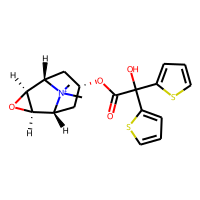
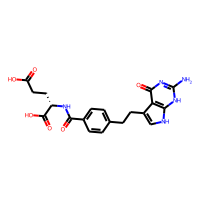
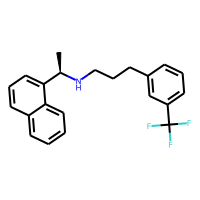
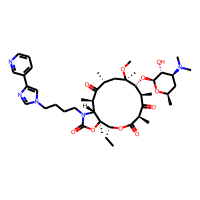
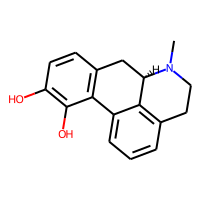

In [72]:
# Generating the Mol Structure
PandasTools.AddMoleculeColumnToFrame(db, "smiles")
db.head(5)

In [75]:
# Calculating the lipinski's descriptors
db["mw"] = db["ROMol"].apply(Descriptors.ExactMolWt) #peso molecular
db["n_hba"] = db["ROMol"].apply(Descriptors.NumHAcceptors)
db["n_hbd"] = db["ROMol"].apply(Descriptors.NumHDonors)
db["logp"] = db["ROMol"].apply(Descriptors.MolLogP)

,active_ingredient_moiety,nda_bla,approval_year,active,drugbank_id,drug_groups,smiles,ROMol,mw,n_hba,n_hbd,logp
0,tiotropium bromide,NDA,2004.0,tiotropium,DB01409,approved,[H][C@]12O[C@@]1([H])[C@]1([H])C[C@@]([H])(C[C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",392.098477,6,1,2.34570
1,pemetrexed disodium,NDA,2004.0,pemetrexed,DB00642,approved; investigational,NC1=NC(=O)C2=C(NC=C2CCC2=CC=C(C=C2)C(=O)N[C@@H...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",427.149183,6,6,0.66640
2,cinacalcet hydrochloride,NDA,2004.0,cinacalcet,DB01012,approved,C[C@@H](NCCCC1=CC(=CC=C1)C(F)(F)F)C1=CC=CC2=CC...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",357.170434,1,1,6.14200
3,telithromycin,NDA,2004.0,telithromycin,DB00976,approved,[H][C@@]12[C@@H](C)C(=O)[C@H](C)C[C@@](C)(OC)[...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",811.473143,14,1,4.92920
4,apomorphine hydrochloride,NDA,2004.0,apomorphine,DB00714,approved; investigational,[H][C@]12CC3=C(C(O)=C(O)C=C3)C3=CC=CC(CCN1C)=C23,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",267.125929,3,2,2.84990
...,...,...,...,...,...,...,...,...,...,...,...,...
403,givosiran,NDA,2019.0,givosiran,NaN,NaN,C[C@@H]1C[C@H](CN1C(=O)CCCCCCCCCCC(=O)NC(COCCC...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",1709.968932,30,20,-4.79650
404,viltolarsen,NDA,2020.0,viltolarsen,NaN,NaN,CC1=CN(C(=O)NC1=O)[C@H]2CN(C[C@H](O2)COP(=O)(N...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",6921.356418,148,29,-6.63876
405,dasiglucagon,NDA,2021.0,dasiglucagon,NaN,NaN,C[C@H]([C@@H](C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3379.599700,49,52,-14.68393
406,vosoritide,NDA,2021.0,vosoritide,NaN,NaN,CC[C@H](C)[C@H]1C(=O)NCC(=O)N[C@H](C(=O)N[C@H]...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",4100.098262,61,61,-20.98876

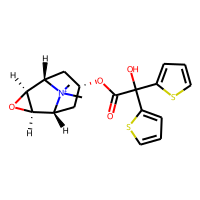
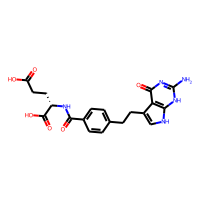
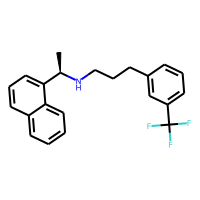
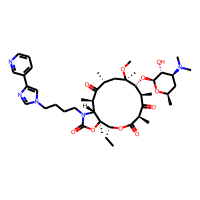
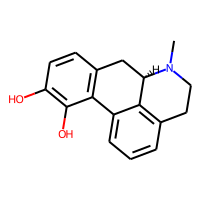
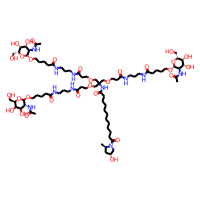
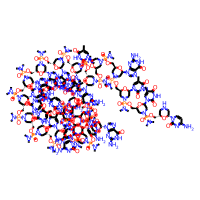
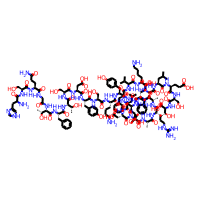
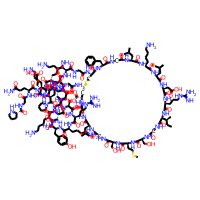
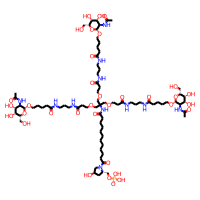

In [76]:
db

In [86]:
db.to_csv("database_fda_db_with_smiles.csv", index = False)